In [1]:
## Loading Required libraries;

library(caret)
library(DMwR)
library(h2o)
library(ROCR)
library(ggplot2)
library(vegan)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'DMwR' was built under R version 3.6.3"Loading required package: grid
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'h2o' was built under R version 3.6.3"
----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

  

In [2]:
# Loading previously prepared datasets

train_data = read.csv(file = "train_data.csv", header = T)
test_data = read.csv(file = "test_data.csv", header = T)

In [6]:
#### Dropping unwanted variables 

train_data$Country <- NULL
train_data$CustomerID <- NULL
train_data$VehicleID <- NULL
train_data$IncidentAddress <- NULL
train_data$InsuredHobbies <- NULL
train_data$InsurancePolicyNumber <- NULL
train_data$Policy_CSL1 <- NULL # Dropping interaction term.Leaving CSL2
train_data$DateOfPolicyCoverage <- NULL
train_data$VehicleModel <- NULL # too many levels
#train_data$InsuredZipCode <- NULL
train_data$DateOfIncident <- NULL

test_data$Country <- NULL
test_data$DateOfPolicyCoverage <- NULL
test_data$DateOfIncident <- NULL
test_data$CustomerID <- NULL
test_data$VehicleID <- NULL
test_data$IncidentAddress <- NULL
test_data$InsuredHobbies <- NULL
#test_data$InsuredZipCode <- NULL
test_data$InsurancePolicyNumber <- NULL
test_data$Policy_CSL1 <- NULL
test_data$VehicleModel <- NULL # too many levels
test_data$id <- NULL
  

In [7]:

####################### RANDOM FOREST


# Split dataset into train and test
set.seed(9585)

train_RowIDs = sample(1:nrow(train_data), nrow(train_data)*0.7)
train_D = train_data[train_RowIDs,]
Val_D = train_data[-train_RowIDs,]
rm(train_RowIDs)



In [8]:


# Build the classification model using randomForest
model = randomForest(ReportedFraud ~ ., data=train_D, 
                     keep.forest=TRUE, ntree=50) 

# Print and understand the model
print(model)



Call:
 randomForest(formula = ReportedFraud ~ ., data = train_D, keep.forest = TRUE,      ntree = 50) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 5

        OOB estimate of  error rate: 9.19%
Confusion matrix:
      N    Y class.error
N 14293  456  0.03091735
Y  1398 4038  0.25717439


In [10]:
# Important attributes
round(importance(model), 2)   

,MeanDecreaseGini
X,1364.12
TypeOfIncident,49.78
TypeOfCollission,62.57
SeverityOfIncident,1048.28
AuthoritiesContacted,121.59
IncidentState,220.95
IncidentCity,225.02
IncidentTime,183.49
NumberOfVehicles,63.78
PropertyDamage,23.92


In [11]:

# Extract and store important variables obtained from the random forest model
rf_Imp_Attr = data.frame(model$importance)
rf_Imp_Attr = data.frame(row.names(rf_Imp_Attr),rf_Imp_Attr[,1])
colnames(rf_Imp_Attr) = c('Attributes', 'Importance')
rf_Imp_Attr = rf_Imp_Attr[order(rf_Imp_Attr$Importance, decreasing = TRUE),]

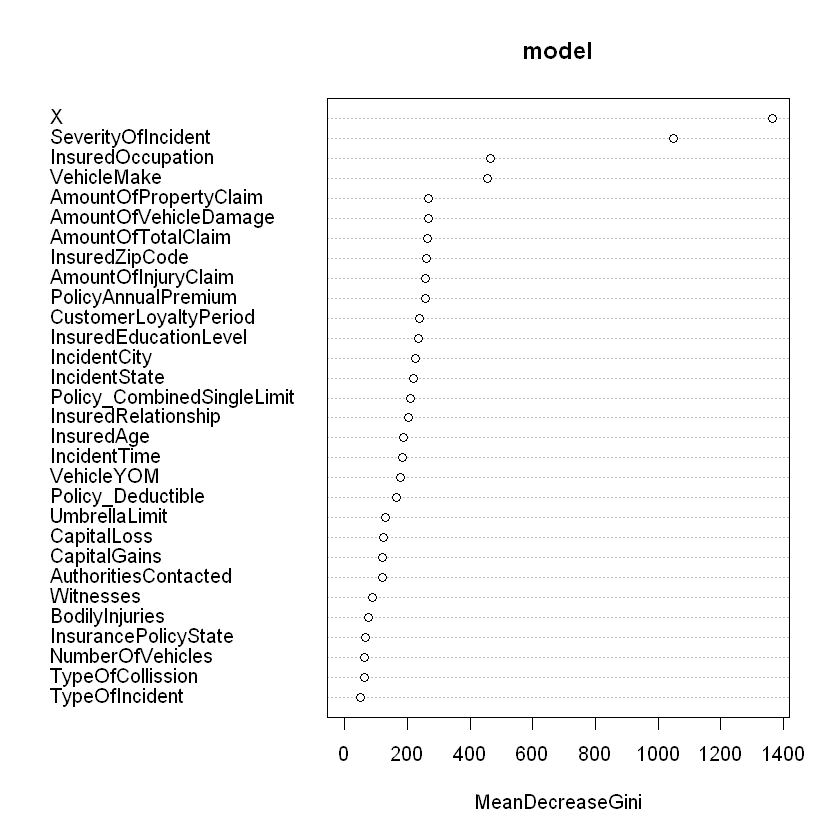

In [12]:
# plot (directly prints the important attributes) 
varImpPlot(model)


In [16]:

# Predicton Test Data
pred_Test = predict(model, Val_D[,setdiff(names(Val_D),
                                          "ReportedFraud")],
                    type="response", 
                    norm.votes=TRUE)

In [17]:
# Build confusion matrix and find accuracy   
cm_Test = table("actual"=Val_D$ReportedFraud, "predicted"=pred_Test);
accu_Test= sum(diag(cm_Test))/sum(cm_Test)
rm(pred_Test, cm_Test)


In [18]:

# Build randorm forest using top 5 important attributes. 
top_Imp_Attr = as.character(rf_Imp_Attr$Attributes[1:5])

In [19]:
# Build the classification model using randomForest
model_Imp = randomForest(ReportedFraud~.,
                         data=train_D[,c(top_Imp_Attr,"ReportedFraud")], 
                         keep.forest=TRUE,ntree=50) 

In [20]:
# Print and understand the model
print(model_Imp)



Call:
 randomForest(formula = ReportedFraud ~ ., data = train_D[, c(top_Imp_Attr,      "ReportedFraud")], keep.forest = TRUE, ntree = 50) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 2

        OOB estimate of  error rate: 11.91%
Confusion matrix:
      N    Y class.error
N 14051  698  0.04732524
Y  1706 3730  0.31383370


In [21]:

# Important attributes
model_Imp$importance  

,MeanDecreaseGini
X,3757.5049
SeverityOfIncident,1129.0092
InsuredOccupation,660.8404
VehicleMake,703.9968
AmountOfPropertyClaim,1364.9458


In [22]:
# Predict on Train data 
pred_Train = predict(model_Imp, train_D[,top_Imp_Attr],
                     type="response", norm.votes=TRUE)



In [23]:

# Build confusion matrix and find accuracy   
cm_Train = table("actual" = train_D$ReportedFraud, 
                 "predicted" = pred_Train);
accu_Train_Imp = sum(diag(cm_Train))/sum(cm_Train)
rm(pred_Train, cm_Train)


In [24]:
# Predicton Test Data
pred_Test = predict(model_Imp, Val_D[,top_Imp_Attr],
                    type="response", norm.votes=TRUE)

In [25]:

# Build confusion matrix and find accuracy   
cm_Test = table("actual" = Val_D$ReportedFraud, 
                "predicted" = pred_Test);
accu_Test_Imp = sum(diag(cm_Test))/sum(cm_Test)
rm(pred_Test, cm_Test)


In [27]:
#accu_Train
accu_Test
accu_Train_Imp
accu_Test_Imp

[1] 0.9156167

[1] 0.9937082

[1] 0.8824413

In [31]:
install.packages('C50')
library(C50)
  
train_b <- train_data
test_b <- test_data
  # Running the C5.0 on non standardized data to get more understandable rules.
  c5_tree = C5.0(train_data$ReportedFraud ~ . , train_b)
  c5_rules = C5.0(train_data$ReportedFraud ~ . , train_b, rules = T)
  print(summary(c5_rules))
  
  
  #Running on standardized data
  c5_tree = C5.0(train_data$ReportedFraud ~ . , train_data)
  c5_rules = C5.0(train_data$ReportedFraud ~ . , train_data, rules = T)
  print(summary(c5_rules))
  
  
  out <- capture.output(summary(c5_rules))
  cat("My title", out, file="summary_of_my_very_long_DT2.txt", sep="///", append=TRUE)
  
  
  preds <- predict(c5_tree, test_data)
  write.csv(preds,"subC51.csv")

Warning message:
"package 'C50' is in use and will not be installed"


Call:
C5.0.formula(formula = train_data$ReportedFraud ~ ., data = train_b, rules = T)


C5.0 [Release 2.07 GPL Edition]  	Sat Jan 02 14:19:06 2021
-------------------------------

Class specified by attribute `outcome'

Read 28836 cases (34 attributes) from undefined.data

Rules:

Rule 1: (795/48, lift 1.3)
	X > 27445
	X <= 28240
	->  class N  [0.939]

Rule 2: (384/23, lift 1.3)
	X > 28452
	->  class N  [0.938]

Rule 3: (828/53, lift 1.3)
	X > 27445
	X <= 28273
	->  class N  [0.935]

Rule 4: (24288/4567, lift 1.1)
	X <= 24288
	->  class N  [0.812]

Rule 5: (40, lift 3.6)
	X > 8378
	X <= 10754
	SeverityOfIncident = Major Damage
	IncidentCity in {City1, City4, City6, City7}
	IncidentTime <= 22
	BodilyInjuries > 1
	InsuredZipCode <= 450947
	->  class Y  [0.976]

Rule 6: (99/2, lift 3.6)
	X > 10754
	SeverityOfIncident = Major Damage
	IncidentState in {State3, State7}
	IncidentTime <= 22
	AmountOfVehicleDamage <= 56034
	InsuredZipCode > 450702
	InsuredEducationLevel in {Associate, College,


Call:
C5.0.formula(formula = train_data$ReportedFraud ~ ., data = train_data, rules
 = T)


C5.0 [Release 2.07 GPL Edition]  	Sat Jan 02 14:19:11 2021
-------------------------------

Class specified by attribute `outcome'

Read 28836 cases (34 attributes) from undefined.data

Rules:

Rule 1: (795/48, lift 1.3)
	X > 27445
	X <= 28240
	->  class N  [0.939]

Rule 2: (384/23, lift 1.3)
	X > 28452
	->  class N  [0.938]

Rule 3: (828/53, lift 1.3)
	X > 27445
	X <= 28273
	->  class N  [0.935]

Rule 4: (24288/4567, lift 1.1)
	X <= 24288
	->  class N  [0.812]

Rule 5: (40, lift 3.6)
	X > 8378
	X <= 10754
	SeverityOfIncident = Major Damage
	IncidentCity in {City1, City4, City6, City7}
	IncidentTime <= 22
	BodilyInjuries > 1
	InsuredZipCode <= 450947
	->  class Y  [0.976]

Rule 6: (99/2, lift 3.6)
	X > 10754
	SeverityOfIncident = Major Damage
	IncidentState in {State3, State7}
	IncidentTime <= 22
	AmountOfVehicleDamage <= 56034
	InsuredZipCode > 450702
	InsuredEducationLevel in {Associate, Coll

In [33]:
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\rohil\AppData\Local\Temp\RtmpC64GVu\filea7841b76a78/h2o_rohil_started_from_r.out
    C:\Users\rohil\AppData\Local\Temp\RtmpC64GVu\filea787fb33183/h2o_rohil_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 2 milliseconds 
    H2O cluster timezone:       Europe/Berlin 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    2 months and 24 days  
    H2O cluster name:           H2O_started_from_R_rohil_cur405 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.98 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H

In [34]:
  
  ############
  
  ###### GBM #######
  
  df <- as.h2o(train_data)
  
  response <- "ReportedFraud"
  predictors <- setdiff(names(train_data), c(response))
  
  splits <- h2o.splitFrame(
    data = df, 
    ratios = c(0.75),   ## only need to specify 2 fractions, the 3rd is implied
    destination_frames = c("train.hex", "test.hex"), seed = 1234
  )
  train <- splits[[1]]
  test  <- splits[[2]]
  
  
  gbm <- h2o.gbm(x = predictors, y = response, training_frame = train)
  
  h2o.auc(h2o.performance(gbm, newdata = test))
  
  #cross-validation
  gbm <- h2o.gbm(x = predictors, y = response, training_frame = train, nfolds = 4, seed = 0xDECAF)
  gbm@model$cross_validation_metrics_summary
  h2o.auc(h2o.performance(gbm, xval = TRUE))
  
  
  # I feel lucky parameters
  
  gbm <- h2o.gbm(
    ## standard model parameters
    x = predictors, 
    y = response, 
    training_frame = train, 
    validation_frame = test,
    
    ## more trees is better if the learning rate is small enough 
    ## here, use "more than enough" trees - we have early stopping
    ntrees = 10000,                                                            
    
    ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
    learn_rate=0.01,                                                         
    
    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
    
    ## sample 80% of rows per tree
    sample_rate = 0.8,                                                       
    
    ## sample 80% of columns per split
    col_sample_rate = 0.8,                                                   
    
    ## fix a random number generator seed for reproducibility
    seed = 1234,                                                             
    
    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10                                                 
  )
  
  h2o.auc(h2o.performance(gbm, newdata =  test))
  
  preds <- h2o.predict(gbm, test)
  
  test1 <- as.h2o(test_data)
  
  preds <- h2o.predict(gbm, test1)
  
  
  head(preds)
  
  gbm@model$validation_metrics@metrics$max_criteria_and_metric_scores
  
  
  h2o.exportFile(preds, "SubC.csv", force=TRUE)

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


[1] 0.9061118

  |======================================================================| 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
accuracy,0.89792067,0.0061953817,0.8967292,0.9002201,0.8900241,0.90470934
auc,0.8959762,0.0017643286,0.8962285,0.89355224,0.89634025,0.89778364
aucpr,0.8347352,0.005123487,0.828449,0.8408971,0.8355902,0.8340045
err,0.10207932,0.0061953817,0.10327086,0.0997799,0.10997585,0.09529065
err_count,554.0,31.112698,562.0,544.0,592.0,518.0
f0point5,0.8300434,0.010238556,0.8256044,0.8401952,0.8178221,0.83655185
f1,0.79846275,0.0074708844,0.7944404,0.80203784,0.79036826,0.80700445
f2,0.76922756,0.0069087204,0.7655435,0.76719576,0.76469785,0.7794731
lift_top_group,3.5305653,0.08703096,3.5410624,3.5546315,3.4097548,3.6168127
logloss,0.30684045,0.008405033,0.30995366,0.3042022,0.31648144,0.2967245


[1] 0.8960876

  |======================================================================| 100%


[1] 0.9151041

  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


predict,N,Y
N,0.9475777,0.05242226
N,0.9445633,0.05543670
N,0.9585806,0.04141943
N,0.9454687,0.05453127
N,0.9575199,0.04248009
N,0.9361430,0.06385695


metric,threshold,value,idx
max f1,0.39763579,0.8448608,189
max f2,0.21130531,0.8302021,247
max f0point5,0.50256772,0.8891596,162
max accuracy,0.42200347,0.9209603,184
max precision,0.97386647,0.9803922,6
max recall,0.02030552,1.0000000,397
max specificity,0.98735902,0.9998070,0
max absolute_mcc,0.39763579,0.7957162,189
max min_per_class_accuracy,0.16058806,0.8609681,271
max mean_per_class_accuracy,0.30502909,0.8837000,214


  |======================================================================| 100%
